# LSTM pipeline

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore

In [ ]:
#csv file path
CSV_PATH = 'real5g_scenarios1-5.csv'
LABEL_COLUMN = 'ran_ue_value'
TEST_SIZE = 0.1
SEED = 42
EPOCHS = 50
BATCH_SIZE = 32

In [112]:
# Load data
data_path = CSV_PATH
raw_df = pd.read_csv(data_path)

In [113]:
# Inspect data
print("\nData preview:")
raw_df.head()


Data preview:


,timestamp,amf_session_value,bearers_active_value,fivegs_amffunction_amf_authreject_value,fivegs_amffunction_amf_authreq_value,fivegs_amffunction_mm_confupdate_value,fivegs_amffunction_mm_confupdatesucc_value,fivegs_amffunction_mm_paging5greq_value,fivegs_amffunction_mm_paging5gsucc_value,fivegs_amffunction_rm_regemergreq_value,...,process_cpu_seconds_total_value,process_max_fds_value,process_open_fds_value,process_resident_memory_bytes_value,process_start_time_seconds_value,process_virtual_memory_bytes_value,process_virtual_memory_max_bytes_value,ran_ue_value,s5c_rx_createsession_value,s5c_rx_parse_failed_value
0,2025-04-10 12:28:14,2.0,2.0,0.0,10.0,599.0,499.0,1034.0,498.0,0.0,...,43.25,1024.0,29.75,50106368.0,118464611.5,1.404078e+09,-1.0,0.0,0.0,0.0
1,2025-04-10 12:28:15,2.0,2.0,0.0,10.0,599.0,499.0,1034.0,498.0,0.0,...,43.25,1024.0,29.75,50106368.0,118464611.5,1.404078e+09,-1.0,0.0,0.0,0.0
2,2025-04-10 12:28:16,2.0,2.0,0.0,10.0,599.0,499.0,1034.0,498.0,0.0,...,43.25,1024.0,29.75,50106368.0,118464611.5,1.404078e+09,-1.0,0.0,0.0,0.0
3,2025-04-10 12:28:17,2.0,2.0,0.0,10.0,599.0,499.0,1034.0,498.0,0.0,...,43.25,1024.0,29.75,50106368.0,118464611.5,1.404078e+09,-1.0,0.0,0.0,0.0
4,2025-04-10 12:28:18,2.0,2.0,0.0,10.0,599.0,499.0,1034.0,498.0,0.0,...,43.25,1024.0,29.75,50106368.0,118464611.5,1.404078e+09,-1.0,0.0,0.0,0.0


In [114]:
print("\nMissing values:")
raw_df.isnull().sum()


Missing values:


timestamp                                              0
amf_session_value                                      0
bearers_active_value                                   0
fivegs_amffunction_amf_authreject_value                0
fivegs_amffunction_amf_authreq_value                   0
fivegs_amffunction_mm_confupdate_value                 0
fivegs_amffunction_mm_confupdatesucc_value             0
fivegs_amffunction_mm_paging5greq_value                0
fivegs_amffunction_mm_paging5gsucc_value               0
fivegs_amffunction_rm_regemergreq_value                0
fivegs_amffunction_rm_regemergsucc_value               0
fivegs_amffunction_rm_reginitreq_value                 0
fivegs_amffunction_rm_reginitsucc_value                0
fivegs_amffunction_rm_registeredsubnbr_value           0
fivegs_amffunction_rm_regmobreq_value                  0
fivegs_amffunction_rm_regmobsucc_value                 0
fivegs_amffunction_rm_regperiodreq_value               0
fivegs_amffunction_rm_regperiod

In [115]:
# Drop any rows with missing values
raw_df.dropna(inplace=True)

In [116]:
# Encode label column if it exists
if LABEL_COLUMN in raw_df.columns:
    le = LabelEncoder()
    raw_df[LABEL_COLUMN] = le.fit_transform(raw_df[LABEL_COLUMN])
    print("\nLabel classes:", list(le.classes_))


Label classes: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0)]


In [117]:
# Feature selection (exclude timestamp and label)
feature_cols = [col for col in raw_df.columns if col not in ['timestamp', LABEL_COLUMN]]
label_col = LABEL_COLUMN

In [118]:
# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(raw_df[feature_cols])

In [119]:
# Create sequences for LSTM
SEQUENCE_LENGTH = 10  # Number of time steps
X, y = [], []
for i in range(len(scaled_features) - SEQUENCE_LENGTH):
    X.append(scaled_features[i:i + SEQUENCE_LENGTH])
    y.append(raw_df[label_col].iloc[i + SEQUENCE_LENGTH])

X = np.array(X)
y = np.array(y)
y = to_categorical(y)

print(f"\nFinal shape -> X: {X.shape}, y: {y.shape}")


Final shape -> X: (4818, 10, 53), y: (4818, 6)


In [120]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [121]:
# Build LSTM model
model = Sequential([
    LSTM(128, input_shape=(SEQUENCE_LENGTH, X.shape[2]), return_sequences=True),
    LSTM(62, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/davidtruhlar/Documents/FIIT/BP/5GDigitalTwin/Implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [122]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4793 - loss: 1.3284 - val_accuracy: 0.6349 - val_loss: 0.9493
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6138 - loss: 1.0086 - val_accuracy: 0.6328 - val_loss: 0.8684
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6189 - loss: 0.9721 - val_accuracy: 0.6784 - val_loss: 0.8396
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6466 - loss: 0.8990 - val_accuracy: 0.6867 - val_loss: 0.8056
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6565 - loss: 0.8848 - val_accuracy: 0.6805 - val_loss: 0.8057
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6762 - loss: 0.8290 - val_accuracy: 0.7012 - val_loss: 0.7949
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6767 - loss: 0.8344 - val_accuracy: 0.6909 - val_loss: 0.7676
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6830 - loss: 0.7860 - val_accuracy: 0.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7305 - loss: 0.7346 

Test Accuracy: 0.7324


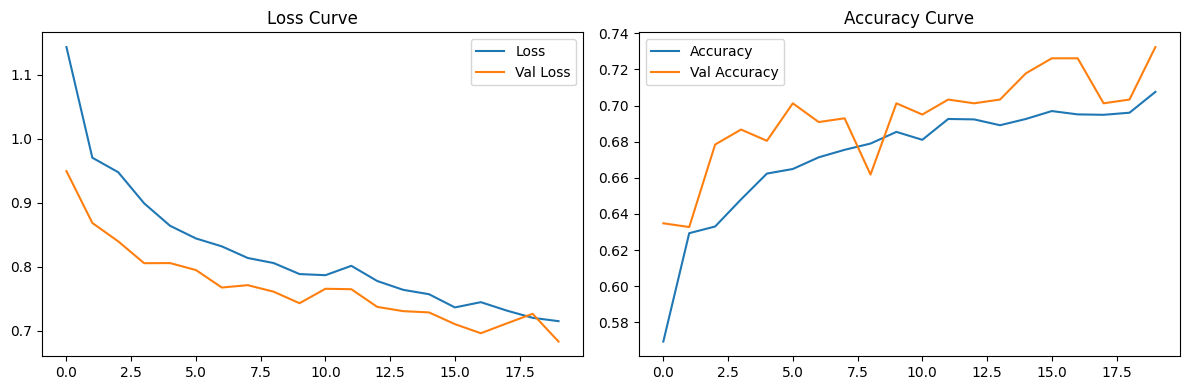

In [123]:
# Evaluate model
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()
